# Predicting the resolution of protein structures using X-ray diffraction data

This notebook we will be trying to predict the resolution of the protein structured data which has been analyzed in the first part of this project. Will be using different classification algorithms and will try to tune hyperparameters to get optimum results. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('after_eda_data.csv')

In [3]:
df.head()

,Angle_beta_(°),Angle_gamma_(°),Collection_Temperature,Detector,Diffraction_Source_General_Class,Matthews_Coefficient,Percent_Solvent_Content,Total_Number_of_Polymer_Instances_(Chains),Resolution_(Å),R_Free,Reflections_For_Refinement,Structure_Determination_Method,Minimum_Diffraction_Wavelength,Maximum_Diffraction_Wavelength,Crystal_cell_volum
0,90.00,90.0,100.0,IMAGE PLATE,SYNCHROTRON,3.00,34.00,1,No,0.299,7634.0,MULTIPLE ISOMORPHOUS REPLACEMENT,0.9000,1.1000,4.308345e+05
1,131.91,90.0,93.0,IMAGE PLATE,ROTATING ANODE,2.49,51.03,2,No,0.267,22321.0,MOLECULAR REPLACEMENT,1.5418,1.5418,6.437038e+05
2,90.00,90.0,100.0,CCD,SYNCHROTRON,2.25,45.00,3,No,0.264,11938.0,"MR, CROSS-CRYSTAL A",0.9194,0.9194,6.604790e+05
3,90.00,90.0,300.0,IMAGE PLATE,ROTATING ANODE,3.87,68.20,1,No,0.258,14853.0,MOLECULAR REPLACEMENT,1.5418,1.5418,6.518244e+06
4,90.00,90.0,283.0,IMAGE PLATE,ROTATING ANODE,2.77,56.00,1,No,0.268,8382.0,MOLECULAR REPLACEMENT,1.5418,1.5418,2.343045e+05


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108064 entries, 0 to 108063
Data columns (total 15 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Angle_beta_(°)                              108064 non-null  float64
 1   Angle_gamma_(°)                             108064 non-null  float64
 2   Collection_Temperature                      108064 non-null  float64
 3   Detector                                    108064 non-null  object 
 4   Diffraction_Source_General_Class            108064 non-null  object 
 5   Matthews_Coefficient                        108064 non-null  float64
 6   Percent_Solvent_Content                     108064 non-null  float64
 7   Total_Number_of_Polymer_Instances_(Chains)  108064 non-null  int64  
 8   Resolution_(Å)                              108064 non-null  object 
 9   R_Free                                      108064 non-null  float64
 

In [5]:
df.describe(include='object')

,Detector,Diffraction_Source_General_Class,Resolution_(Å),Structure_Determination_Method
count,108064,108064,108064,108064
unique,19,10,2,513
top,CCD,SYNCHROTRON,Yes,MOLECULAR REPLACEMENT
freq,61202,94079,55436,85068


In [6]:

df['Resolution_(Å)']=df['Resolution_(Å)'].replace('Yes',1)
df['Resolution_(Å)']=df['Resolution_(Å)'].replace('No',0)
df.describe(include='object')

,Detector,Diffraction_Source_General_Class,Structure_Determination_Method
count,108064,108064,108064
unique,19,10,513
top,CCD,SYNCHROTRON,MOLECULAR REPLACEMENT
freq,61202,94079,85068


#### List of numerical columns

In [7]:
numerical_vars = df.select_dtypes(exclude= "object")
numerical_vars = numerical_vars.columns.tolist()
numerical_vars.remove('Resolution_(Å)')
numerical_vars

['Angle_beta_(°)',
 'Angle_gamma_(°)',
 'Collection_Temperature',
 'Matthews_Coefficient',
 'Percent_Solvent_Content',
 'Total_Number_of_Polymer_Instances_(Chains)',
 'R_Free',
 'Reflections_For_Refinement',
 'Minimum_Diffraction_Wavelength',
 'Maximum_Diffraction_Wavelength',
 'Crystal_cell_volum']

#### List of categorical columns

In [8]:
categorical_vars = df.select_dtypes(include= "object")
categorical_vars= categorical_vars.columns.tolist()
#categorical_vars.remove('Resolution_(Å)')
categorical_vars

['Detector',
 'Diffraction_Source_General_Class',
 'Structure_Determination_Method']

####  Splitting the dataset into test and train examples

In [9]:
from sklearn.model_selection import train_test_split
features = [x for x in df.columns if x != 'Resolution_(Å)']

X = df[features]
y = df['Resolution_(Å)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=124)
print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

Training examples: 86,451
Test examples: 21,613


#### Creating preprocessing pipeline for numerical and categorical columns

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


num_pipeline = Pipeline([('scale', StandardScaler()) ])

car_pipeline = Pipeline([('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])



#### Using a Logistic Regression model to predict the values

In [11]:
from sklearn.linear_model import LogisticRegression

processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, numerical_vars),
                                                      ('create_dummies', car_pipeline, categorical_vars)])


lg_model = Pipeline([('data_processing', processing_pipeline),
                              ('logreg', LogisticRegression(penalty='none'))])

In [12]:
from sklearn.model_selection import cross_validate
# ignoring the warnings 
import warnings
warnings.filterwarnings("ignore")


cv_results = cross_validate(lg_model, X_train, y_train, 
                            scoring=['accuracy', 'recall', 'precision', 'f1_macro', 'roc_auc'], cv=5)
cv_results

{'fit_time': array([1.13046503, 1.07808304, 0.97309518, 1.07360005, 1.02384424]),
 'score_time': array([0.09453702, 0.09800315, 0.09569192, 0.11331201, 0.09479284]),
 'test_accuracy': array([0.8445434 , 0.83637941, 0.83811452, 0.84089069, 0.83713129]),
 'test_recall': array([0.85986902, 0.84912479, 0.84833427, 0.85578769, 0.84372177]),
 'test_precision': array([0.84032222, 0.834332  , 0.83764496, 0.83716306, 0.83917341]),
 'test_f1_macro': array([0.84433872, 0.83619699, 0.83796053, 0.84068781, 0.83701085]),
 'test_roc_auc': array([0.92329704, 0.92001143, 0.91994534, 0.92311597, 0.91864613])}

> The dataset we are using is pretty balanced so will use accuracy to optimize our hyperparameters. This cross validation results shows without regularization, models performance is fair with max accuracy of 0.84.

#### Regularization helps to solve the overfitting when we have too many parameters making the dataset complex. So will use l2 regularization in our model.

For the regularization, C parameter in Logistic Regression we will start with values that are spacing on a logarithmic scale.


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


params = {'lg__C': [0.01, 0.1, 1, 10], 'lg__penalty':['l2', 'none']}

lg_l2_model = Pipeline([('pp', processing_pipeline), 
                     ('lg', LogisticRegression())
                    ])

lg_l2_gscv = GridSearchCV(lg_l2_model, param_grid=params)
lg_l2_gscv = lg_l2_gscv.fit(X_train, y_train)

lg_l2_gscv.best_estimator_

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['Angle_beta_(°)',
                                                   'Angle_gamma_(°)',
                                                   'Collection_Temperature',
                                                   'Matthews_Coefficient',
                                                   'Percent_Solvent_Content',
                                                   'Total_Number_of_Polymer_Instances_(Chains)',
                                                   'R_Free',
                                                   'Reflections_For_Refinement',
                                                   'Minimum_Diffraction_Wavelength',
                                                   'Ma

In [14]:
lg_l2_gscv.best_score_

0.8395275336390429

> C=10 provides the best model with the training and validation data as it maximizes accuracy. Will search around the value 10 to find if there is value for which will get more accuracy value.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time

start = time.process_time()

params = {'lg__C': [5, 8, 10, 12,15], 'lg__penalty':['l2', 'none']}

lg_l2_model = Pipeline([('pp', processing_pipeline), 
                     ('lg', LogisticRegression())
                    ])

lg_l2_gscv = GridSearchCV(lg_l2_model, param_grid=params)
lg_l2_gscv = lg_l2_gscv.fit(X_train, y_train)

lg_l2_time= time.process_time() - start

lg_l2_gscv.best_estimator_

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['Angle_beta_(°)',
                                                   'Angle_gamma_(°)',
                                                   'Collection_Temperature',
                                                   'Matthews_Coefficient',
                                                   'Percent_Solvent_Content',
                                                   'Total_Number_of_Polymer_Instances_(Chains)',
                                                   'R_Free',
                                                   'Reflections_For_Refinement',
                                                   'Minimum_Diffraction_Wavelength',
                                                   'Ma

In [17]:
lg_l2_gscv.best_score_

0.8396547768258638

In [18]:
from sklearn.metrics import classification_report

lg_l2_pred_evt = lg_l2_gscv.predict(X_test)

print(classification_report(y_test, lg_l2_pred_evt))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83     10454
           1       0.84      0.85      0.85     11159

    accuracy                           0.84     21613
   macro avg       0.84      0.84      0.84     21613
weighted avg       0.84      0.84      0.84     21613



> C=10 is still showing the best performance after a secondary targeted hyperparameter search.There is slight increase in accuracy score so will go ahead with this parameter value. 

In [19]:
from sklearn.metrics import classification_report

lg_l2_pred_evt = lg_l2_gscv.predict(X_train)

print(classification_report(y_train, lg_l2_pred_evt))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83     42174
           1       0.84      0.85      0.85     44277

    accuracy                           0.84     86451
   macro avg       0.84      0.84      0.84     86451
weighted avg       0.84      0.84      0.84     86451



> Logistic regression model's performance is same for test and training data. 

#### Using PCA on numerical columns to reduce the dimensionality of the dataset. 

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

n_comp_list=[5,6,7,8,9,10]

for i in n_comp_list:
    num_pipeline = Pipeline([('scale', StandardScaler()), ('pca', PCA(n_components=i)) ])
    car_pipeline = Pipeline([('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])


    processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, numerical_vars),
                                                      ('create_dummies', car_pipeline, categorical_vars)])


    modeling_pipeline = Pipeline([('data_processing', processing_pipeline),
                              ('logreg', LogisticRegression(penalty='none'))])

    pca_model=modeling_pipeline.fit(X_train, y_train)
    pca_y_predicted = pca_model.predict(X_test)


    print('Accuracy for %d n_components :'%(i),accuracy_score(y_test, pca_y_predicted))

Accuracy for 5 n_components : 0.8138157590339148
Accuracy for 6 n_components : 0.8167769398047472
Accuracy for 7 n_components : 0.8163142553093046
Accuracy for 8 n_components : 0.8202008050710221
Accuracy for 9 n_components : 0.8286679313376208
Accuracy for 10 n_components : 0.8397723592282422


> I have tried using different n_component values for the numeric column pipeline. But it is not showing any improvement. All the n-component values have less accuracy than the previous logistic regression with regularization model.

#### Using Decision Tree Classifier to predict the values.

In [21]:
from sklearn.tree import DecisionTreeClassifier

num_pipeline = Pipeline([('scale', StandardScaler())])
car_pipeline = Pipeline([('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])


processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, numerical_vars),
                                                      ('create_dummies', car_pipeline, categorical_vars)])


dt_modeling_pipeline = Pipeline([('data_processing', processing_pipeline),
                                ('dt', DecisionTreeClassifier())])

param_grid = [
  {'dt__max_depth': [2, 5, 10, 15, 20],
   'dt__min_samples_split':[0.01, 0.05, 0.10]}]


gcv_results = GridSearchCV(estimator=dt_modeling_pipeline,param_grid=param_grid)

gcv_results = gcv_results.fit(X_train, y_train)

gcv_results.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['Angle_beta_(°)',
                                                   'Angle_gamma_(°)',
                                                   'Collection_Temperature',
                                                   'Matthews_Coefficient',
                                                   'Percent_Solvent_Content',
                                                   'Total_Number_of_Polymer_Instances_(Chains)',
                                                   'R_Free',
                                                   'Reflections_For_Refinement',
                                                   'Minimum_Diffraction_Wavelength',
                                         

In [22]:
gcv_results.best_score_

0.8368092903234092

In [23]:
from sklearn.metrics import classification_report

dt_pred_evt = gcv_results.predict(X_test)

print(classification_report(y_test, dt_pred_evt))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84     10454
           1       0.84      0.86      0.85     11159

    accuracy                           0.84     21613
   macro avg       0.84      0.84      0.84     21613
weighted avg       0.84      0.84      0.84     21613



> Decision tree classifier is giving best performance for max_depth of 10 or value near to 10 could be preferred. Also it is using 1% minimum sample split. Currently model is giving 0.84 accuracy with 85% precision and 86% recall. To further improve the results of the classifier we will try to search for better values near this first choice of the hyperparameters by doing secondary search. 

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
start = time.process_time()
params = {'dt__max_depth': [8,9,10, 11, 12, 13],
          'dt__min_samples_split':[0.005,0.007,0.01, 0.02, 0.03]
         }

dt_model = Pipeline([('data_processing', processing_pipeline), ('dt', DecisionTreeClassifier())])

dt = GridSearchCV(dt_model, param_grid=params)
dt = dt.fit(X_train, y_train)

df_time= time.process_time() - start

dt.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['Angle_beta_(°)',
                                                   'Angle_gamma_(°)',
                                                   'Collection_Temperature',
                                                   'Matthews_Coefficient',
                                                   'Percent_Solvent_Content',
                                                   'Total_Number_of_Polymer_Instances_(Chains)',
                                                   'R_Free',
                                                   'Reflections_For_Refinement',
                                                   'Minimum_Diffraction_Wavelength',
                                         

In [25]:
from sklearn.metrics import classification_report

dt_pred_evt = dt.predict(X_test)

print(classification_report(y_test, dt_pred_evt))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     10454
           1       0.86      0.86      0.86     11159

    accuracy                           0.85     21613
   macro avg       0.85      0.85      0.85     21613
weighted avg       0.85      0.85      0.85     21613



> In secondary search also max_depth =10 but the min_sample_split = 0.005 which is half the value from the first parameter search which was 1%. This change has increased the accuracy by 1% and precision value by 2%. So far the Decision tree classifier model with max_depth =10 and the min_sample_split = 0.005 has given the best result.

In [26]:
from sklearn.metrics import classification_report

dt_pred_evt = dt.predict(X_train)

print(classification_report(y_train, dt_pred_evt))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86     42174
           1       0.87      0.86      0.86     44277

    accuracy                           0.86     86451
   macro avg       0.86      0.86      0.86     86451
weighted avg       0.86      0.86      0.86     86451



> If we compare performance of the model on the test and training data we don't see much overfitting. Model's performance on training data is 1% higher than the test data which is good.

### Result



In [31]:
print(f'Logistic Regression, Training: {lg_l2_gscv.score(X_train, y_train)}')
print(f'Logistic Regression, Test: {lg_l2_gscv.score(X_test, y_test)}')

print(f'Decision Tree, Training: {dt.score(X_train, y_train)}')
print(f'Decision Tree, Test: {dt.score(X_test, y_test)}')

Logistic Regression, Training: 0.8400365524979468
Logistic Regression, Test: 0.8404663859714061
Decision Tree, Training: 0.8605221454928226
Decision Tree, Test: 0.8546707999814926


> Above score shows the models performance on test and training data. There is not much of a difference for both the models. Which proves that the model is not overfitting to the particular data.

#### Comparing the ROC curve for best performing Logistic Regression and Decision Tree model.

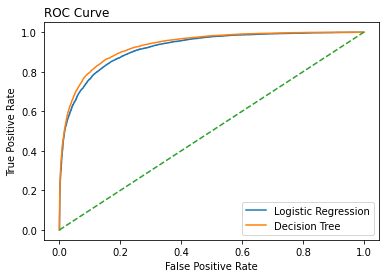

In [33]:
from sklearn.metrics import roc_curve

lg_pred =lg_l2_gscv.predict_proba(X_test)
dt_pred = dt.predict_proba(X_test)

lg_fpr, lg_tpr, lg_thr = roc_curve(y_test, lg_pred[:,1])
dt_fpr, dt_tpr, dt_thr = roc_curve(y_test, dt_pred[:,1])


plt.plot(lg_fpr, lg_tpr)
plt.plot(dt_fpr, dt_tpr)
plt.plot(lg_fpr, lg_fpr, linestyle='dashed')
plt.title('ROC Curve', loc='left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Logistic Regression', 'Decision Tree'], loc='lower right')
plt.show()

> ROC curve for the Decision tree is slightly better than the Logistic regression model. Both the models are showing similar trade-offs between TPR and FPR. Overall both the curves are far from the diagonal which proves both the model does a fair job at predicting the values. 

In [34]:
print("Time taken by Logistic Regression Model:",lg_l2_time)

print("Time taken by Decision Tree Model:",df_time)

Time taken by Logistic Regression Model: 40.144172999999995
Time taken by Decision Tree Model: 126.78127800000001


> Decision Tree model is taking more time than the Logistic regression model.

Considering all the factors we can say that DecisionTreeClassifier is the best performing model so far. If we want to try on a very large amount of data DT model might take more time and it will be computationally expensive as compared to LR for 1% of increase in accuracy. 

### Areas which can be further explored. 

The PDB dataset which has been used in this project has more than 300 features for each protein structure for different categories. As we only considered X-ray diffraction and protein structure properties data we initially extracted 42 features from it and finally used 14 features for the prediction. To further analyze we can try training our model on other features as well like Z-number, Crystallization Method,Crystal Growth Procedure etc. 

In this project we tried to predict the Resolution value which is between (1 to 3) by converting into boolean values. But without converting it into binary class we could try using multiclass classification models to predict the resolution. It might give better prediction probability.

### References 

- [RCSB Protein Data Bank](https://www.rcsb.org/)
- [PDB Dataset](https://bit.ly/3K0LUJq)
- [Resolution](https://pdb101.rcsb.org/learn/guide-to-understanding-pdb-data/resolution)
- [Assignment - Comparing Models](https://github.com/appliedecon/data602-lectures/blob/main/sample-solutions/2022-Spring/comparing-models-answered.ipynb)